This is a simpified version of the other test notebooks that only does training.

In [1]:
# Enable this for some more verbose info.
debugging = False
import tensorflow as tf
from keras import backend as K
K.clear_session()

/home/saad/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Common imports

In [2]:
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import random
import collections

# Root directory of the project
ROOT_DIR = os.path.abspath("../")
ROOT_IMAGE_DIR = os.path.abspath("images/")

# Path to the dataset (note this is a shared images directory)
dataset_path = os.path.join(ROOT_IMAGE_DIR, "signs")

models_dir = os.path.join(ROOT_DIR, "csci_e89_project/models/")

print("base dataset dir:", dataset_path)
print("base modesl dir:", models_dir)

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import model as modellib, utils

from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn.model import log

# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")


base dataset dir: /home/saad/notebook/csci_e89/project/saad_mrcnn/csci_e89_project/images/signs
base modesl dir: /home/saad/notebook/csci_e89/project/saad_mrcnn/csci_e89_project/models/


In [3]:
# for visualization
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon

%matplotlib inline 

In [4]:
# TODO refactor the DataSet code to a separate python file.
sys.path.append(os.path.join(ROOT_DIR, "csci_e89_project/"))  # To find local version
import csci_e89_project.det as det


In [5]:
############################################################
#  Configurations
############################################################

class SignConfig(det.DetConfig):
    """Configuration for training on the dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "sign"

    # A GPU with 12GB memory can fit two images.
    IMAGES_PER_GPU = 3

    CLASS_NAMES = ['sign', 'yield_sign', 'stop_sign', 'oneway_sign', 'donotenter_sign', 'wrongway_sign']
    
    ALL_CLASS_NAMES = ['BG'] + CLASS_NAMES

    # Number of classes (including background)
    NUM_CLASSES = len(ALL_CLASS_NAMES)
    
    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100    # TODO was 100

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9
    
    TRAINING_VERBOSE = 1

    TRAIN_BN = False
    #  'relu' or 'leakyrelu'
    ACTIVATION = 'relu'

In [6]:
############################################################
#  Dataset
############################################################

# Example usage:
# Load images from a training directory use the convienence function for taking from one directory and spliting into train and test
#   dataset_train, dataset_val = create_datasets(dataset_path+'/train', config.CLASS_NAMES)

class SignDataset(utils.Dataset):

    def __init__(self, dataset_name):
        self.dataset_name = dataset_name
        self.map_name_to_id = {}
        utils.Dataset.__init__(self)
        
        
    def load_by_annotations(self, dataset_dir, annotations_list, class_ids):
        """Load a specfic set of annotations and from them images.
        dataset_dir: Root directory of the dataset.
        annotations_list: The annotations (and images) to be loaded.
        class_ids: List of classes to use.
        """
        
        ann_class_names = set()
        for a in annotations_list:
            regions = a['regions']
            for r, v in regions.items():
                ann_class_names.add(v['region_attributes']['object_name'])
        
        # Add classes. Use class_ids to ensure consistency.
        for i, name in enumerate(class_ids):
            # Skip over background if it appears in the class name list 
            index = i + 1
            if name != 'BG':
                print('Adding class {:3}:{}'.format(index, name))
                self.add_class('sign', index, name)
                self.map_name_to_id[name] = index

        # Add images
        for a in annotations_list:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. There are stores in the
            # shape_attributes (see json format above)
            polygons = [r['shape_attributes'] for r in a['regions'].values()]
            
            r_object_name = [r['region_attributes']['object_name'] for r in a['regions'].values()]
            
            assert len(polygons) == len(r_object_name)            

            # load_mask() needs the image shape.
            image_path = os.path.join(dataset_dir, a['filename'])
            height = a['height']
            width = a['width']
            
            self.add_image(
                "sign",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                r_object_name=r_object_name)
                    


    def load_mask(self, image_id):
        """Generate instance masks for an image.
        Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """

        # If not an object in our dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] not in self.class_names:
            print("warning: source {} not part of our classes, delegating to parent.".format(image_info["source"]))
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        class_ids = []
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            try:
                rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
                mask[rr, cc, i] = 1
                class_id = self.map_name_to_id[info['r_object_name'][i]]
                class_ids.append(class_id)
            except:
                print(image_info)
                raise

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        class_ids = np.array(class_ids, dtype=np.int32)
        return mask.astype(np.bool), class_ids

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == self.dataset_name:
            return info["path"]
        else:
            print("warning: DetDataSet: using parent image_reference for: ", info["source"])
            super(self.__class__, self).image_reference(image_id)

            
            
def split_annotations(dataset_dir, train_pct=.8, annotation_filename="annotations.json"):
    """ divide up an annotation file for training and validation
    dataset_dir: location of images and annotation file.
    train_pct: the split between train and val default is .8
    annotation_filename: name of annotation file.
    """

    # Load annotations
    annotations = json.load(open(os.path.join(dataset_dir, annotation_filename)))
    annotations = list(annotations.values())  # don't need the dict keys

    # The VIA tool saves images in the JSON even if they don't have any
    # annotations. Skip unannotated images.
    annotations = [a for a in annotations if a['regions']]

    # Find the unique classes and track their count
    uniq_class_names = collections.Counter()
    for a in annotations:
        for id, region in a['regions'].items():
            object_name = region['region_attributes']['object_name']
            uniq_class_names[object_name] += 1

    n_annotations = len(annotations)

    # Randomize the annotations then divide
    np.random.shuffle(annotations)

    # Divide between training and validation
    n_for_train = int(n_annotations*train_pct)
    train_ann = annotations[:n_for_train]
    val_ann = annotations[n_for_train:]

    def validate_unique(ann, img_files={}):
        for a in ann:
            filename = a['filename']
            if filename in img_files:
                raise RuntimeError(filename+' already exists')
            else:
                img_files[filename] = 1
        return img_files

    img_files = validate_unique(train_ann)
    img_files = validate_unique(val_ann, img_files)
    assert len(train_ann)+len(val_ann)  == len(img_files)

    return train_ann, val_ann, uniq_class_names


def create_datasets(dataset_dir, class_ids, train_pct=.8):
    """ set up the training and validation trainng set.
    dataset_dir: location of images and annotation file.
    class_ids: list of classes that being trained for.
    train_pct: the split between train and val default is .8
    """

    # TODO if the dataset is shuffled, it is possible for 
    # either the training or val set to not get one or more of the classes.
    # This is even more likely with smaller number of classes. This is the error
    # ValueError: Error when checking input: expected input_image_meta to have shape (19,) but got array with shape (17,)
    train_ann, val_ann, object_counts = split_annotations(dataset_dir, train_pct=train_pct)

    train_ds = SignDataset('sign')
    train_ds.load_by_annotations(dataset_dir, train_ann, class_ids)

    val_ds = SignDataset('sign')
    val_ds.load_by_annotations(dataset_dir, val_ann, class_ids)

    assert len(train_ds.image_info) == len(train_ann) and len(val_ds.image_info) == len(val_ann)

    return train_ds, val_ds            

## Augmentation

In [7]:
# The imgaug library is pretty flexible and make different types of augmentation possible. 
# The deterministic setting is used because any spatial changes to the image must also be 
# done to the mask. There are also some augmentors that are unsafe to apply. From the mrcnn
# library: 
# Augmentors that are safe to apply to masks: 
# ["Sequential", "SomeOf", "OneOf", "Sometimes","Fliplr", 
# "Flipud", "CropAndPad", "Affine", "PiecewiseAffine"]
# Affine, has settings that are unsafe, so always
# test your augmentation on masks

import imgaug as ia
from imgaug import augmenters as iaa

ia.seed(1)

# http://imgaug.readthedocs.io/en/latest/source/augmenters.html#sequential
seq_of_aug = iaa.Sequential([
    iaa.Crop(percent=(0, 0.1)), # random crops
    
    # horizontally flip 50% of the images
    #iaa.Fliplr(0.5), # Does not make sense for signs

    # Gaussian blur to 50% of the images
    # with random sigma between 0 and 0.5.
    iaa.Sometimes(0.4,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    
    # Strengthen or weaken the contrast in each image.
    iaa.ContrastNormalization((0.75, 1.5)),
    
    # Add gaussian noise.
    # For 50% of all images, we sample the noise once per pixel.
    # For the other 50% of all images, we sample the noise per pixel AND
    # channel. This can change the color (not only brightness) of the
    # pixels.
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    
    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
    
    # Apply affine transformations to each image.
    # Scale/zoom them from 90% 5o 110%
    # Translate/move them, rotate them
    # Shear them slightly -2 to 2 degrees.
    iaa.Affine(
        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-5, 5),
        shear=(-2, 2)
    )
], random_order=True) # apply augmenters in random order


# Train

The default implementation uses the ResNet101 and FPN networks. These are very large and they recommend a GPU with 12GB or an Amazon P2 instance. Due to the size, I am training with a BATCH_SIZE of 2.

In [8]:
print("dataset dir:", dataset_path)
print("modesl dir:", models_dir)

dataset dir: /home/saad/notebook/csci_e89/project/saad_mrcnn/csci_e89_project/images/signs
modesl dir: /home/saad/notebook/csci_e89/project/saad_mrcnn/csci_e89_project/models/


In [9]:
# Setup configuration
config = SignConfig()
config.display()


Configurations:
ACTIVATION                     relu
ALL_CLASS_NAMES                ['BG', 'sign', 'yield_sign', 'stop_sign', 'oneway_sign', 'donotenter_sign', 'wrongway_sign']
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     3
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
CLASS_NAMES                    ['sign', 'yield_sign', 'stop_sign', 'oneway_sign', 'donotenter_sign', 'wrongway_sign']
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                19
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                  

In [10]:
# Create the model
model = modellib.MaskRCNN(mode='training', 
                          config=config,
                          model_dir=models_dir)

model.keras_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, None, None, 3 0           input_image[0][0]                
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNorm)            (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [11]:
# Load the weights

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(models_dir, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)
else:
    print("using existing ", COCO_MODEL_PATH)
    
# For the coco dataset exclude the last layers because 
# it requires a matching number of classes
print("loading...", end='')
model.load_weights(COCO_MODEL_PATH, by_name=True, exclude=[
    "mrcnn_class_logits", "mrcnn_bbox_fc",
    "mrcnn_bbox", "mrcnn_mask"])

print("loaded.")

using existing  /home/saad/notebook/csci_e89/project/saad_mrcnn/csci_e89_project/models/mask_rcnn_coco.h5
loading...loaded.


In [12]:
def train(model, dataset_path, epochs=30):
    """Train the model."""
    
    # Create the train and val dataset.
    dataset_train, dataset_val = create_datasets(dataset_path+'/train', config.CLASS_NAMES)

    # Prepare them
    dataset_train.prepare()
    dataset_val.prepare()

    # Experiment with training options.
    # Since we're using a very small dataset, and starting from
    # COCO trained weights, we don't need to train too long. Also,
    # no need to train all layers, just the heads should do it.
    print("Training network heads")
    history = model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=epochs,
                layers='heads', 
                augmentation=seq_of_aug
                )
    
    return history

In [13]:
history = train(model, dataset_path, 75)

Adding class   1:sign
Adding class   2:yield_sign
Adding class   3:stop_sign
Adding class   4:oneway_sign
Adding class   5:donotenter_sign
Adding class   6:wrongway_sign
Adding class   1:sign
Adding class   2:yield_sign
Adding class   3:stop_sign
Adding class   4:oneway_sign
Adding class   5:donotenter_sign
Adding class   6:wrongway_sign
Training network heads

Starting at epoch 0. LR=0.001

Checkpoint Path: /home/saad/notebook/csci_e89/project/saad_mrcnn/csci_e89_project/models/sign20180511T0132/mask_rcnn_sign_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1  

/home/saad/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/75
100/100 [==============================] - 113s 1s/step - loss: 1.4145 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.2439 - mrcnn_class_loss: 0.1507 - mrcnn_bbox_loss: 0.5838 - mrcnn_mask_loss: 0.4264 - val_loss: 0.8492 - val_rpn_class_loss: 0.0063 - val_rpn_bbox_loss: 0.1114 - val_mrcnn_class_loss: 0.1115 - val_mrcnn_bbox_loss: 0.4044 - val_mrcnn_mask_loss: 0.2156
Epoch 2/75
100/100 [==============================] - 102s 1s/step - loss: 0.6893 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.1655 - mrcnn_class_loss: 0.0677 - mrcnn_bbox_loss: 0.2453 - mrcnn_mask_loss: 0.2035 - val_loss: 0.6343 - val_rpn_class_loss: 0.0061 - val_rpn_bbox_loss: 0.0900 - val_mrcnn_class_loss: 0.1038 - val_mrcnn_bbox_loss: 0.2780 - val_mrcnn_mask_loss: 0.1564
Epoch 3/75
100/100 [==============================] - 102s 1s/step - loss: 0.6151 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1489 - mrcnn_class_loss: 0.0588 - mrcnn_bbox_loss: 0.2137 - mrcnn_mask_loss: 0.1871 - val_loss: 0.5620 - val_rpn_class_l

Epoch 23/75
100/100 [==============================] - 101s 1s/step - loss: 0.2416 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0670 - mrcnn_class_loss: 0.0128 - mrcnn_bbox_loss: 0.0595 - mrcnn_mask_loss: 0.0998 - val_loss: 0.5143 - val_rpn_class_loss: 0.0033 - val_rpn_bbox_loss: 0.1685 - val_mrcnn_class_loss: 0.0596 - val_mrcnn_bbox_loss: 0.1415 - val_mrcnn_mask_loss: 0.1415
Epoch 24/75
100/100 [==============================] - 101s 1s/step - loss: 0.2478 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0778 - mrcnn_class_loss: 0.0121 - mrcnn_bbox_loss: 0.0584 - mrcnn_mask_loss: 0.0969 - val_loss: 0.5366 - val_rpn_class_loss: 0.0033 - val_rpn_bbox_loss: 0.1654 - val_mrcnn_class_loss: 0.0537 - val_mrcnn_bbox_loss: 0.1612 - val_mrcnn_mask_loss: 0.1531
Epoch 25/75
100/100 [==============================] - 100s 1s/step - loss: 0.2454 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0774 - mrcnn_class_loss: 0.0129 - mrcnn_bbox_loss: 0.0566 - mrcnn_mask_loss: 0.0958 - val_loss: 0.5364 - val_rpn_clas

Epoch 45/75
100/100 [==============================] - 101s 1s/step - loss: 0.2069 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0681 - mrcnn_class_loss: 0.0112 - mrcnn_bbox_loss: 0.0409 - mrcnn_mask_loss: 0.0843 - val_loss: 0.5100 - val_rpn_class_loss: 0.0041 - val_rpn_bbox_loss: 0.1590 - val_mrcnn_class_loss: 0.0501 - val_mrcnn_bbox_loss: 0.1339 - val_mrcnn_mask_loss: 0.1630
Epoch 46/75
100/100 [==============================] - 101s 1s/step - loss: 0.2027 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0724 - mrcnn_class_loss: 0.0082 - mrcnn_bbox_loss: 0.0372 - mrcnn_mask_loss: 0.0826 - val_loss: 0.5206 - val_rpn_class_loss: 0.0035 - val_rpn_bbox_loss: 0.1601 - val_mrcnn_class_loss: 0.0615 - val_mrcnn_bbox_loss: 0.1354 - val_mrcnn_mask_loss: 0.1600
Epoch 47/75
100/100 [==============================] - 101s 1s/step - loss: 0.2114 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0782 - mrcnn_class_loss: 0.0089 - mrcnn_bbox_loss: 0.0386 - mrcnn_mask_loss: 0.0829 - val_loss: 0.5205 - val_rpn_clas

Epoch 67/75
100/100 [==============================] - 101s 1s/step - loss: 0.2098 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0911 - mrcnn_class_loss: 0.0075 - mrcnn_bbox_loss: 0.0304 - mrcnn_mask_loss: 0.0783 - val_loss: 0.4920 - val_rpn_class_loss: 0.0034 - val_rpn_bbox_loss: 0.1280 - val_mrcnn_class_loss: 0.0696 - val_mrcnn_bbox_loss: 0.1273 - val_mrcnn_mask_loss: 0.1638
Epoch 68/75
100/100 [==============================] - 101s 1s/step - loss: 0.1812 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0583 - mrcnn_class_loss: 0.0081 - mrcnn_bbox_loss: 0.0350 - mrcnn_mask_loss: 0.0781 - val_loss: 0.4982 - val_rpn_class_loss: 0.0037 - val_rpn_bbox_loss: 0.1509 - val_mrcnn_class_loss: 0.0600 - val_mrcnn_bbox_loss: 0.1329 - val_mrcnn_mask_loss: 0.1507
Epoch 69/75
100/100 [==============================] - 100s 1s/step - loss: 0.1967 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0834 - mrcnn_class_loss: 0.0068 - mrcnn_bbox_loss: 0.0298 - mrcnn_mask_loss: 0.0747 - val_loss: 0.5048 - val_rpn_clas

In [14]:
print(history.history.keys())

dict_keys(['val_loss', 'val_rpn_class_loss', 'val_rpn_bbox_loss', 'val_mrcnn_class_loss', 'val_mrcnn_bbox_loss', 'val_mrcnn_mask_loss', 'loss', 'rpn_class_loss', 'rpn_bbox_loss', 'mrcnn_class_loss', 'mrcnn_bbox_loss', 'mrcnn_mask_loss'])


In [15]:
import math

def plot_history(history):
    
    fig = plt.figure(figsize=(16,10))
       
    n_history_loss = len(history.history)
    n_epochs = len(history.epoch)
    epoch = history.epoch
    
    # The loss is in pairs, one for train, one for val
    loss_stats = [ k for k in history.history.keys() if 'val_' not in k ]
    
    n_cols = 4
    n_rows = math.ceil(len(loss_stats) / n_cols) 
    
    for i, k in enumerate(loss_stats):
        val_k = 'val_'+k
        ax = plt.subplot( n_rows, n_cols, i+1)
        ax.plot(epoch, history.history[k], label=k)
        ax.plot(epoch, history.history[val_k], label=val_k)
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Loss')
        ax.set_title(str(i)+' - '+k)
        plt.legend(shadow=True, fancybox=True)
    
    fig.tight_layout()
    plt.show()
    
    

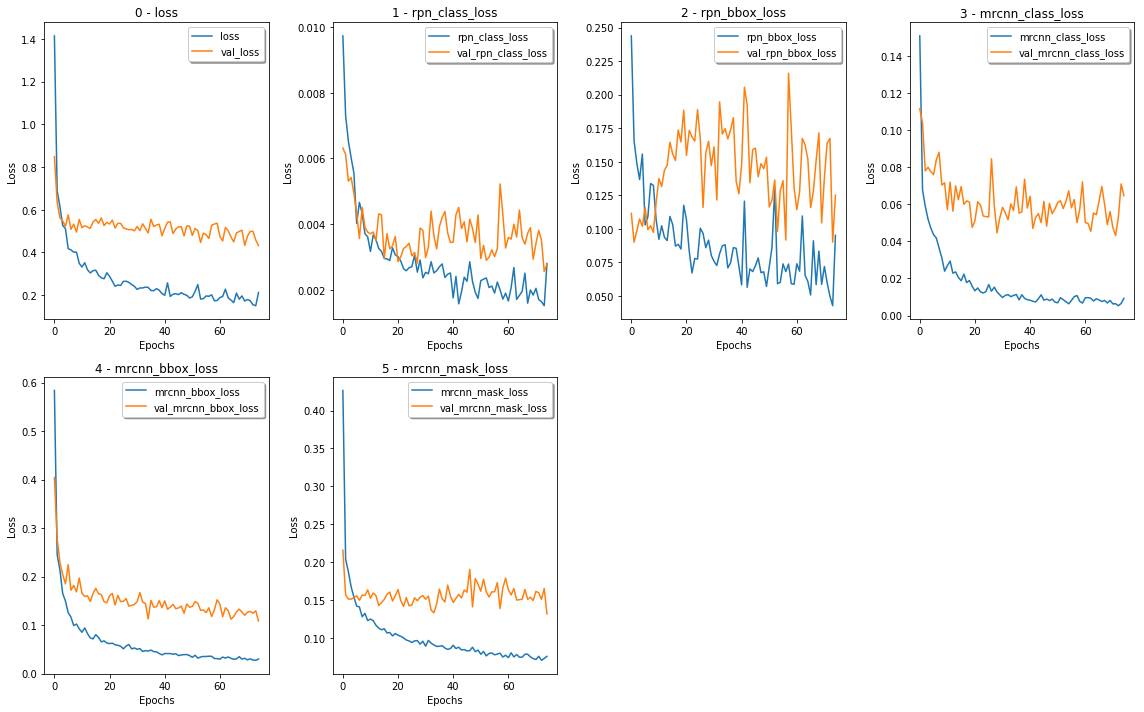

In [16]:
# Plot training stats for each of the networks.
plot_history(history)

# Inference

In [17]:
class InferenceConfig(SignConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
inf_config = InferenceConfig()
inf_model = modellib.MaskRCNN(mode="inference", 
                              config=inf_config,
                              model_dir=models_dir)

inf_config.display()

# Find last trained weights
weights_path = inf_model.find_last()[1]

# enabled for testing
#weights_path = os.path.join(models_dir, "sign20180508T1523_mask_rcnn_sign_0075.h5")

print("Using weights: ", weights_path)

inf_model.load_weights(weights_path, by_name=True)



Configurations:
ACTIVATION                     relu
ALL_CLASS_NAMES                ['BG', 'sign', 'yield_sign', 'stop_sign', 'oneway_sign', 'donotenter_sign', 'wrongway_sign']
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
CLASS_NAMES                    ['sign', 'yield_sign', 'stop_sign', 'oneway_sign', 'donotenter_sign', 'wrongway_sign']
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                19
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                  

In [18]:
import glob

def detect_instance(class_names, image_test_dir):
    """
    class_names: list of class names of the dataset
    image_filenames: list of images to analyze
    """

    det_filenames = sorted(glob.glob(image_test_dir+'/*'))

    for f in det_filenames:
        print("Processing image {}".format(f))

        test_img = plt.imread(f)
        print(test_img.shape)

        plt.imshow(test_img)
        # visualize.display_images([test_img])

        # Included in the results from detect are the found:
        # class_ids,their scores and masks.
        results = inf_model.detect([test_img], verbose=1)[0]

        print("Objects detected: ", len(results['class_ids']))

        # Visualize results
        visualize.display_instances(test_img, 
                                    results['rois'], 
                                    results['masks'], 
                                    results['class_ids'], 
                                    class_names, 
                                    results['scores'])

        print(results['class_ids'])

In [19]:
import time

def detect_instances(class_names, image_test_dir):
    """
    class_names: list of class names of the dataset
    image_filenames: list of images to analyze
    """
        
    det_filenames = sorted(glob.glob(image_test_dir+'/*'))

    fig = plt.figure(figsize=(16,10))

    n_cols = 3
    n_rows = math.ceil(len(det_filenames) / n_cols) 
    
    
    for i, f in enumerate(det_filenames):
        
        print("Processing image {}".format(f))
        
        ax = plt.subplot( n_rows, n_cols, i+1)

        test_img = plt.imread(f)

        start_time = time.time()
        
        # Included in the results from detect are the found:
        # class_ids,their scores and masks.
        results = inf_model.detect([test_img], verbose=1)[0]
        
        elapsed_time = time.time() - start_time

        print("Elapsed time: {:.4f}, Objects detected: {}".format( elapsed_time, len(results['class_ids'])))

        # Visualize results
        visualize.display_instances(test_img, 
                                    results['rois'], 
                                    results['masks'], 
                                    results['class_ids'], 
                                    class_names, 
                                    results['scores'],
                                    ax=ax)

        print(results['class_ids'])
        



Processing image /home/saad/notebook/csci_e89/project/saad_mrcnn/csci_e89_project/images/signs/test/2-sm-dupontcircle-8791.jpg
Processing 1 images
image                    shape: (400, 600, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 19)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Elapsed time: 1.2706, Objects detected: 1
[4]
Processing image /home/saad/notebook/csci_e89/project/saad_mrcnn/csci_e89_project/images/signs/test/IMG_4716.jpg
Processing 1 images
image                    shape: (481, 360, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  131.30000  float64
image_metas              shape: (1, 19)               min:    0.00000  max: 1024.00000  float64
anchor

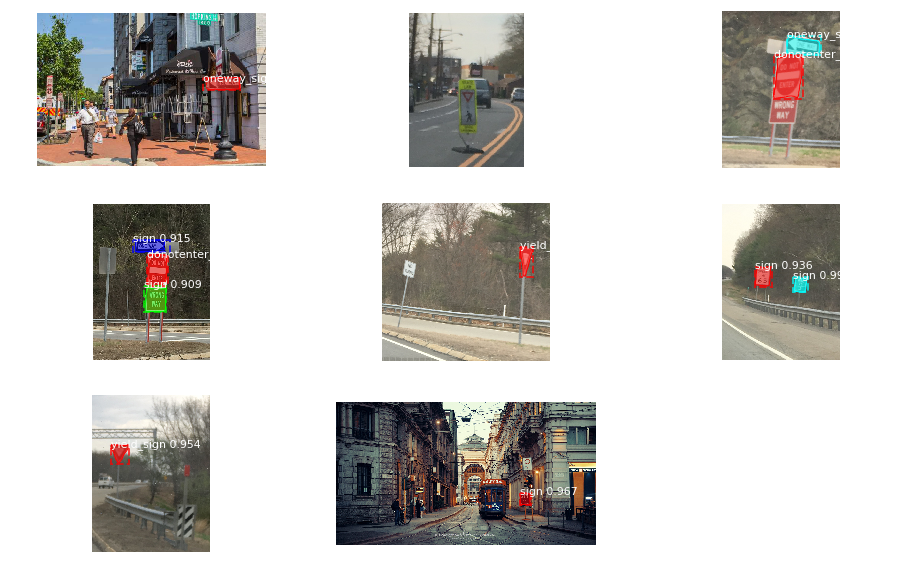

In [20]:
image_test_dir = os.path.join(dataset_path, "test/")

if debugging:
    r = detect_instance(inf_config.ALL_CLASS_NAMES, image_test_dir)
else:
    r = detect_instances(inf_config.ALL_CLASS_NAMES, image_test_dir)